<a href="https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/Kdd_cup_final_VIS_AKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [310]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [311]:
# from google.colab import drive
# drive.mount('/content/drive')

In [312]:
f2_score = make_scorer(fbeta_score, beta=2)

In [313]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab files/Project - ML2/orange_small_train.data', sep='\t')
# df_train = pd.read_csv('/content/drive/MyDrive/KDD_cup/orange_small_train.data', sep='\t')

In [314]:
df_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,80.0,NaN,4.0,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [315]:
y_train_churn = pd.read_table('/content/drive/MyDrive/Colab files/Project - ML2/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
# y_train_churn = pd.read_table('/content/drive/MyDrive/KDD_cup/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
y_train_churn.head()

0   -1
1    1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [316]:
# y_train_appetency =pd.read_table('/content/drive/MyDrive/ML-2 project/data/orange_small_train_appetency.labels',header = None).loc[:, 0].astype('category')
# y_train_appetency.head()

In [317]:
# y_train_upselling= pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_upselling.labels', header = None).loc[:, 0].astype('category')
# y_train_upselling.head()

In [318]:
# df_test = pd.read_table('/content/drive/MyDrive/KDD_cup/orange_small_test.data')
# df_test.head()

Change the lables from [-1, 1] to [0, 1]

In [319]:
# y_train_appetency = (y_train_appetency.astype('int') + 1)/2
y_train_churn = (y_train_churn.astype('int') + 1)/2
# y_train_upselling = (y_train_upselling.astype('int') + 1)/2

In [320]:
# y_train_appetency.tail()

In [321]:
# np.mean(y_train_appetency == 1) , np.mean(y_train_churn == 1) , np.mean(y_train_upselling == 1)

In [322]:
print(np.mean(y_train_churn == 1))
print(y_train_churn.value_counts())

0.07344
0.0    46328
1.0     3672
Name: 0, dtype: int64


In [323]:
# y_train_appetency.value_counts()

In [324]:
# y_train_upselling.value_counts()

In [325]:
# fig, axes = plt.subplots(1,3, figsize=(20,6))
# axes[0].hist(y_train_churn, bins=3)
# axes[0].set_title('Churn Label distribution')
# axes[1].hist(y_train_appetency, bins=3)
# axes[1].set_title('Appetency Label distribution')
# axes[2].hist(y_train_upselling, bins=3)
# axes[2].set_title('Upselling label distribution')
# plt.show()

### Preprocessing

In [326]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [327]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [328]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (50000, 230)


,dtype,nulls,num_uniques,value_counts
Var1,float64,49298,19,HC
Var2,float64,48759,3,nan:487590.0:12405.0:1
Var3,float64,48760,147,HC
Var4,float64,48421,5,nan:484210.0:15619.0:1518.0:227.0:1
Var5,float64,48513,572,HC
Var6,float64,5529,1487,HC
Var7,float64,5539,9,7.0:235300.0:13090nan:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var8,float64,50000,1,nan:50000
Var9,float64,49298,101,HC
Var10,float64,48513,535,HC


In [329]:
df_train.shape

(50000, 230)

Table Shape (50000, 230)


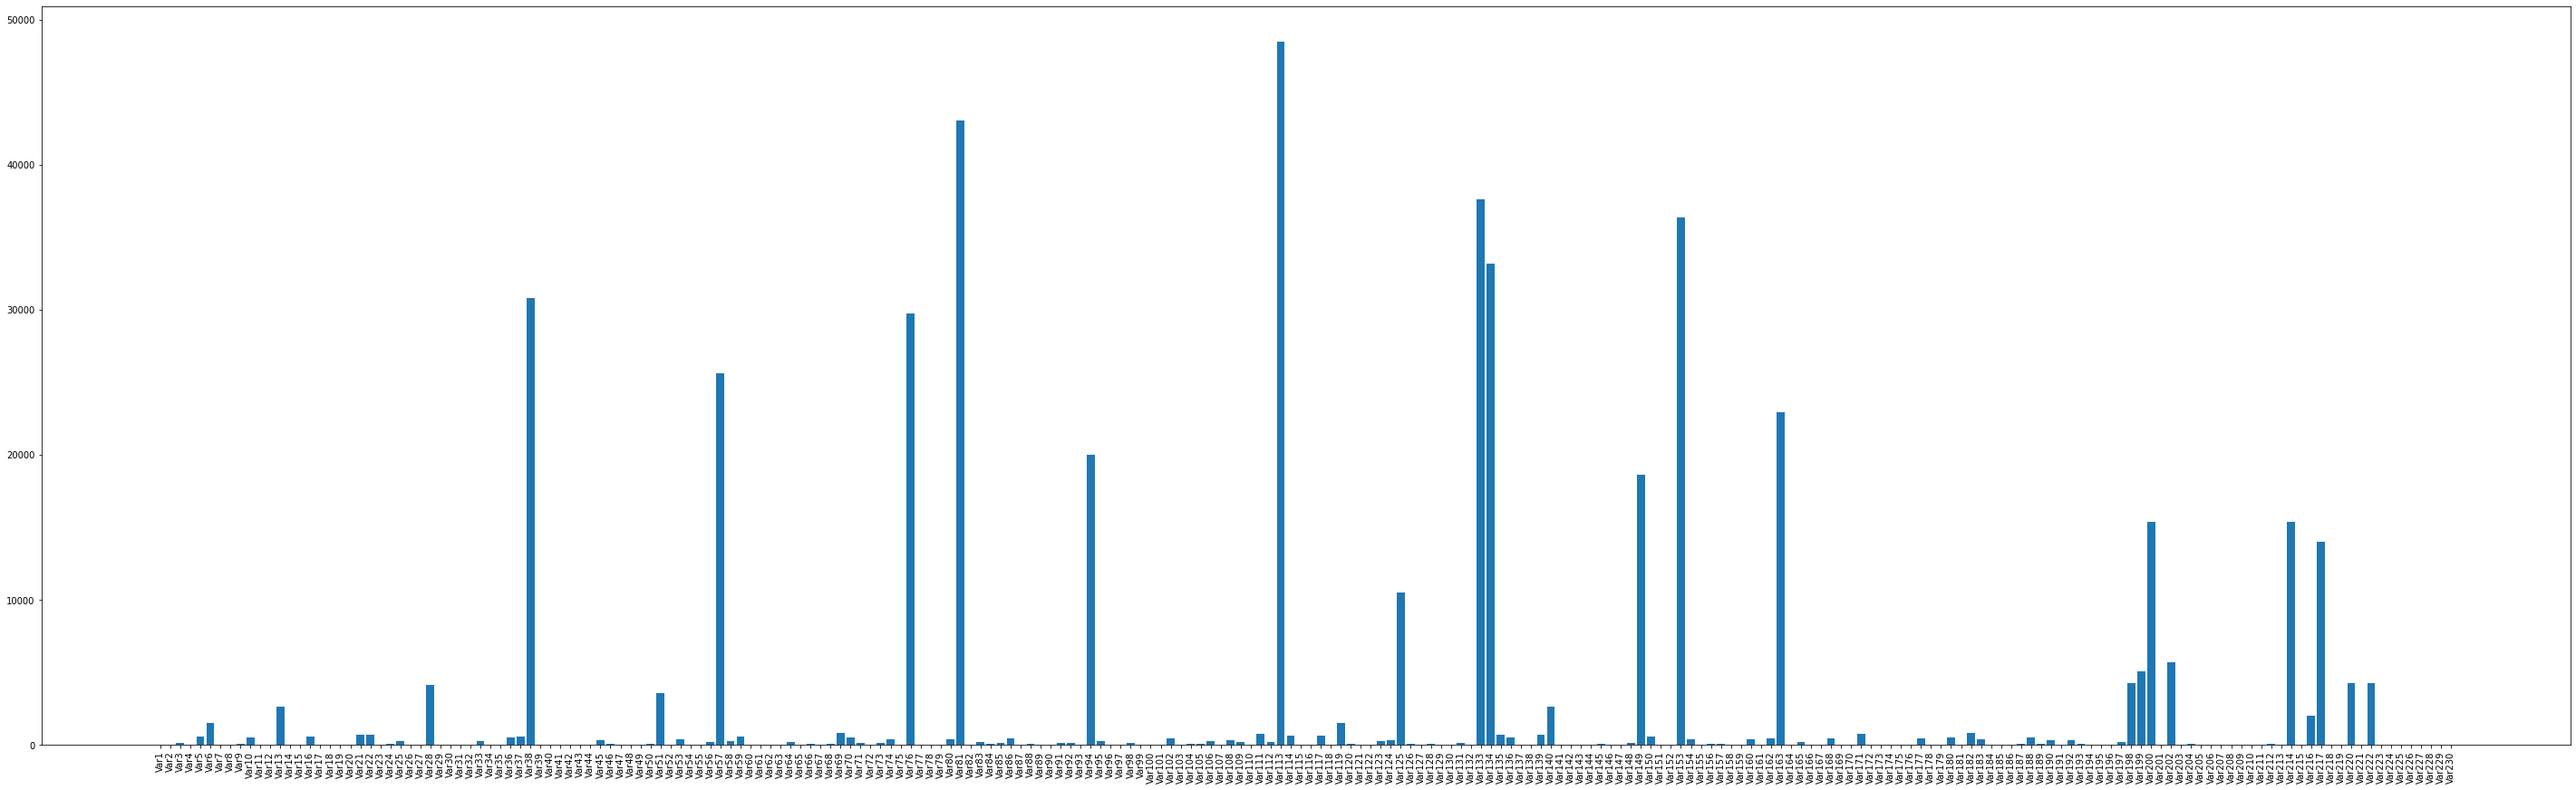

In [330]:
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

plt.figure(figsize=(50,15))
plt.bar(table_report.index, table_report['num_uniques'])
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [331]:
df_table = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']) # Using the second tbl_report function

df_table['dtype'].value_counts()

Table Shape (50000, 230)


float64    191
object      38
int64        1
Name: dtype, dtype: int64

In [332]:
df_float = df_table[df_table['dtype']== 'float64']
lst_empty_float_cols = list(df_float[df_float['nulls'] > len(df_train)*0.95 ].index)
print("Number of float cols where more than 95% of data is null = ",len(lst_empty_float_cols))

Number of float cols where more than 95% of data is null =  149


In [333]:
df_object = df_table[df_table['dtype']== 'object']
lst_empty_categorical_cols = list(df_object[df_object['nulls'] > len(df_train)*0.95 ].index)
print("Number of categorical cols where more than 95% of data is null = ",len(lst_empty_categorical_cols))

Number of categorical cols where more than 95% of data is null =  4


In [334]:
drop_cols = lst_empty_float_cols + lst_empty_categorical_cols
print("Total columns to be dropped =",len(drop_cols))

Total columns to be dropped = 153


In [335]:
df_train_kdd = df_train.drop(drop_cols,axis=1)

In [336]:
categorical_cols = list(df_train_kdd.dtypes[df_train_kdd.dtypes == 'object'].index)
continuous_cols = list(df_train_kdd.dtypes[(df_train_kdd.dtypes == 'float64') | (df_train_kdd.dtypes == 'int64')].index)

In [337]:
df_train_cat_cols = df_train_kdd[categorical_cols].fillna('o') # CHECK THIS

In [338]:
encoder = OrdinalEncoder()
# transform data
encoder.fit(df_train_cat_cols)
encoded_train_cat_cols = encoder.transform(df_train_cat_cols)

In [339]:
df_train_kdd[categorical_cols] = pd.DataFrame(encoded_train_cat_cols, columns=categorical_cols)


Train-test-split

In [340]:
X_train, X_val, y_train, y_val = train_test_split(df_train_kdd, y_train_churn, random_state=66, train_size=0.8, stratify=y_train_churn)


In [341]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

In [342]:
def upsample_downsample(X, y):
    # define oversampling strategy
    over_sample = RandomOverSampler(sampling_strategy=0.2,random_state=42)
    X_over, y_over = over_sample.fit_resample(X, y)

    # define under sampling strategy
    under_sample = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
    X_balanced, y_balanced = under_sample.fit_resample(X_over, y_over)
    return X_balanced, y_balanced

In [343]:
X_balanced, y_balanced = upsample_downsample(X_train, y_train)
print(X_balanced.shape, y_balanced.shape)

(22236, 77) (22236,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [344]:
X_balanced = pd.DataFrame(X_balanced,columns=X_train.columns)

In [345]:
cont_cols_df_X = X_balanced[continuous_cols]

### Standard Scaler

In [346]:
scaler = StandardScaler()
scaler.fit(cont_cols_df_X)
scaled_X_balanced = scaler.transform(cont_cols_df_X)

In [347]:
X_balanced_scaled = pd.DataFrame(scaled_X_balanced,columns=continuous_cols).join(X_balanced[categorical_cols])
X_balanced_scaled.columns = X_balanced.columns

In [348]:
X_val_scaled = pd.DataFrame(scaler.transform(X_val[continuous_cols])).join(X_val[categorical_cols])
X_val_scaled.columns = X_balanced.columns

Feature Selection

In [349]:
!pip install rfpimp
from rfpimp import plot_corr_heatmap, plot_dependence_heatmap, feature_dependence_matrix, feature_corr_matrix

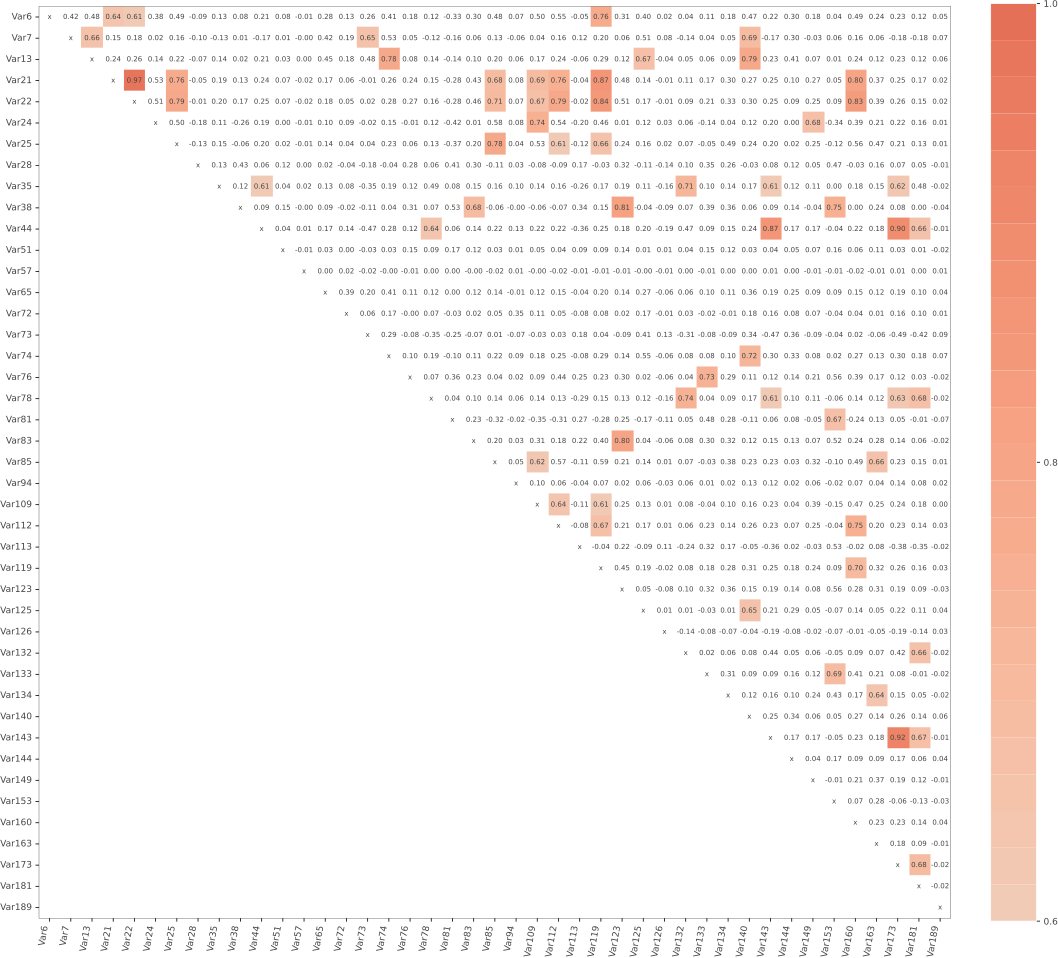

In [350]:
viz = plot_corr_heatmap(X_balanced_scaled[continuous_cols], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

In [351]:
corr_matrix = feature_corr_matrix(X_balanced_scaled).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
len(to_drop)

17

In [352]:
X_balanced_scaled.drop(to_drop, axis=1, inplace=True)

In [358]:
len(set(continuous_cols) - set(to_drop))

28

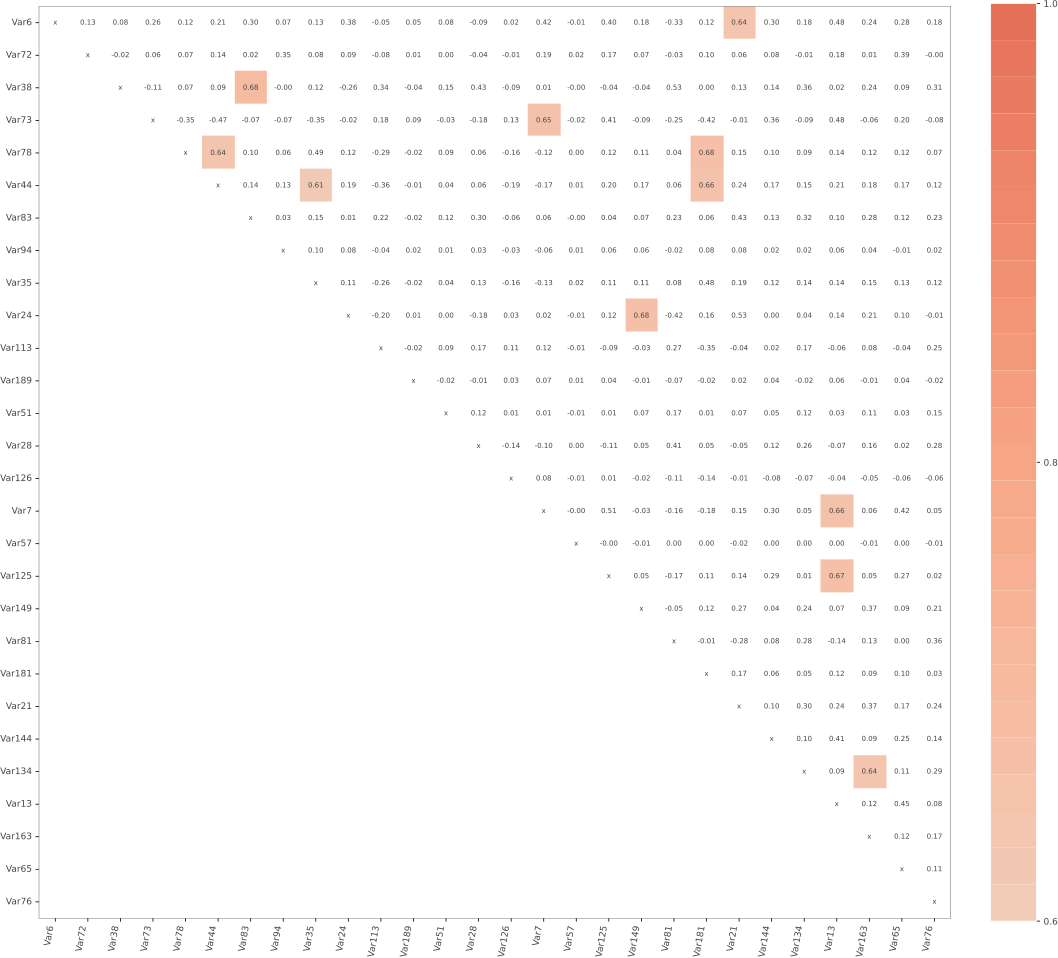

In [359]:
viz = plot_corr_heatmap(X_balanced_scaled[set(continuous_cols) - set(to_drop)], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

In [354]:
drop_corr = []
for col in X_balanced_scaled.columns:
  correl = abs(pearsonr(X_balanced_scaled[col],y_balanced)[0])
  if correl < 0.3:
    drop_corr.append(col)


In [355]:
len(drop_corr)

60